In [1]:
#import libraries
import yfinance as yf
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from IPython.display import display, clear_output
import time

In [2]:
#define date range
start = datetime.datetime(1995, 1, 1)
end = datetime.datetime(2022, 1, 1)
delta = timedelta(days=1)

In [3]:
#define starting variables
symbols = ["^GSPC", "^FTSE", '^DJI', '^IXIC', '^RUT', '^N225']
start_bal = 10000
consecutive = 4
slow_ma = 200
fast_ma = 5

In [4]:
def get_price_data(symbol):
    #download data
    df = yf.download(symbol, start, end)

    #drop redundant columns
    df = df.drop(["Volume", "Adj Close"], axis=1)
    
    return df

In [5]:
def calculate_inputs(df):
    #calculate inputs required for system
    df["oc"] = df.Close / df.Open
    df["hc"] = df.Close / df.High.shift(1)
    df["lc"] = df.Close / df.Low.shift(1)

    #check if today is a down day
    df['LH'] = df.High < df.High.shift(1)
    df['HL'] = df.Low > df.Low.shift(1)

    #count consecutive lower highs
    #https://stackoverflow.com/questions/27626542/counting-consecutive-positive-value-in-python-array
    down = df.LH
    df['Cons_Down'] = down * (down.groupby((down != down.shift()).cumsum()).cumcount() + 1)

    #count consecutive higher lows
    up = df.HL
    df['Cons_Up'] = up * (up.groupby((up != up.shift()).cumsum()).cumcount() + 1)

    return df

In [6]:
def generate_signals(df, s):
    #generate entries and exits
    df["Long_Signal"] = df.Cons_Down >= consecutive
    df["Short_Signal"] = df.Cons_Up >= consecutive
    
    #generate trades
    df["High_Broken"] = np.where((df.Open > df.High.shift(1)) | (df.High >= df.High.shift(1)), True, False)
    df["Low_Broken"] = np.where((df.Open < df.Low.shift(1)) | (df.Low <= df.Low.shift(1)), True, False)
    
    df["Long_Trade"] = np.where((df.Long_Signal.shift(1) & df.High_Broken), True, False)
    df["Short_Trade"] = np.where((df.Short_Signal.shift(1) & df.Low_Broken), True, False)
    

    df['Long_Ret'] = np.where(df.Long_Trade, 
                              np.where(df.Open > df.High.shift(1), df.oc, df.hc),
                         1)# return is from yesterday's high to today's close

    df['Short_Ret'] = np.where((df.Short_Trade) & (df.Long_Trade == False), 
                              np.where(df.Open < df.Low.shift(1), 2 - df.oc, 2 - df.lc),
                         1)# 2 - df is because it is a short trade and return needs to be inverted.
                
    return df

In [7]:
def process_data():
    dfs = []
    for sym in symbols:
        df = get_price_data(sym)
        #calculate strategy inputs
        df = calculate_inputs(df)
        #generate signals
        df = generate_signals(df, sym)
        
        dfs.append(df)

    return dfs

In [8]:
dfs = process_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [9]:
#simulate daily trading
bal = [start_bal]
dates = [start]
in_market = [False]

day = start
#move day by day
while day < end:
    trades = 0
    sum_ret = 0
    sum_ret = 0
    combined_ret = 1
    trading = False
    day += delta
    #check all symbols for a trade
    for df in dfs:
        if day in df.index:
            #get today's data for that index
            data = df.loc[day]
            #check if a trade is triggered for it
            if data.Long_Trade or data.Short_Trade:
                trades += 1
                #sum up the return for each index
                sum_ret = sum_ret + (data.Long_Ret * data.Short_Ret)
            if trades > 0:
                #calculate a combined return for all the trades taken that day
                combined_ret = sum_ret / trades
                trading = True

    #calculate updated balance
    new_bal = bal[-1] * combined_ret
    bal.append(new_bal)
    dates.append(day)
    in_market.append(trading)

In [10]:
results = pd.DataFrame(
    {"Date": dates,
     "Balance": bal,
     "In_Market": in_market,
    })
results = results.set_index("Date")
results

,Balance,In_Market
Date,,
1995-01-01,10000.000000,False
1995-01-02,10000.000000,False
1995-01-03,10000.000000,False
1995-01-04,10000.000000,False
1995-01-05,10000.000000,False
...,...,...
2021-12-28,173865.044081,False
2021-12-29,173578.817058,True
2021-12-30,173569.819017,True


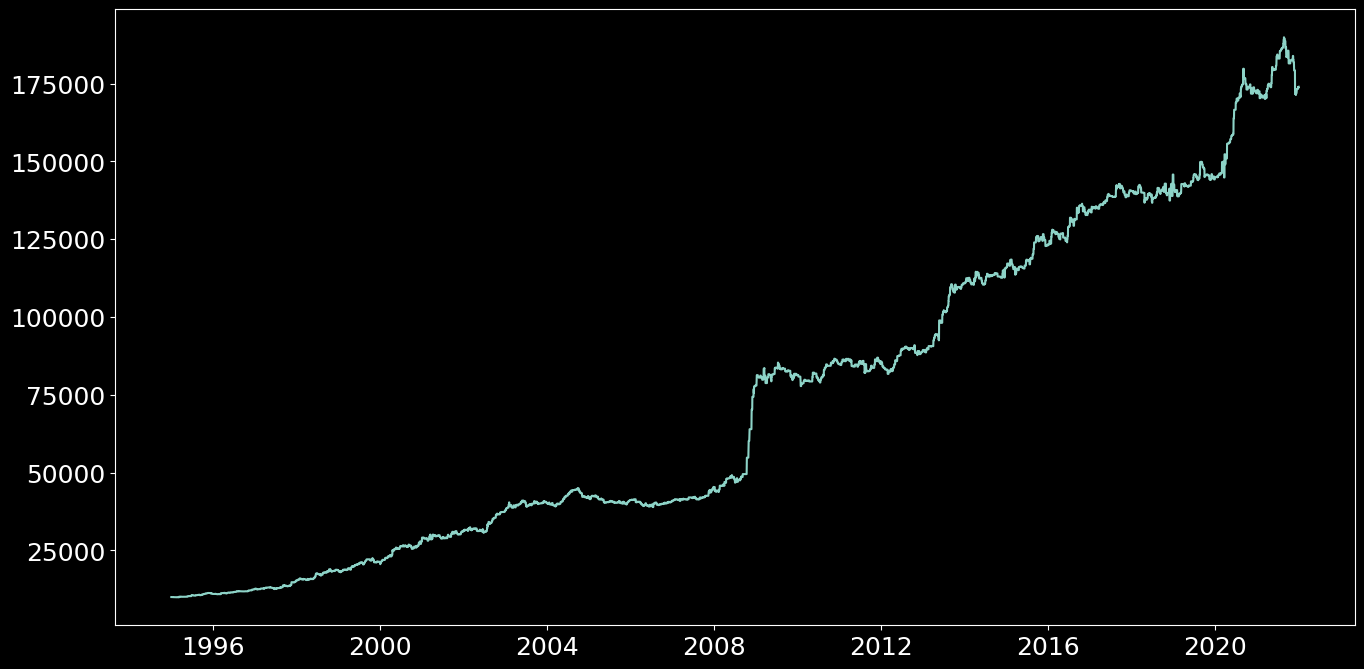

In [11]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams.update({"font.size": 18})

plt.plot(results.Balance)

plt.show()

In [12]:
#metrics
years = (end - start).days / 365.25
end_bal = round(bal[-1])
ret = round(((end_bal / start_bal) - 1) * 100, 2)
cagr = round(((((end_bal / start_bal) ** (1/years))-1)*100), 2)
peak = results["Balance"].cummax()
dd = results["Balance"] - peak
dd_pct = round(((dd / peak).min()) * 100, 2)
rod = round(cagr / abs(dd_pct), 2)
tim = round(results.In_Market.sum() / len(results) * 100, 2)
rbe = round((cagr / tim) * 100, 2)
rbeod = round(rbe / abs(dd_pct), 2) # return by exposure by drawdown (assuming drawdown doesn"t scale as TIM increases. Could be wrong)

print(f"Start Balance: {start_bal:,}")
print(f"Final Balance: {end_bal:,}")
print(f"Total Return: {ret}")
print(f"Annual Return: {cagr}")
print(f"Max Drawdown: {dd_pct}")
print(f"Return over Drawdown: {rod}")
print(f"Time in the Market: {tim}")
print(f"Return By Exposure: {rbe}")
print(f"RBE over Drawdown: {rbeod}")

Start Balance: 10,000
Final Balance: 174,004
Total Return: 1640.04
Annual Return: 11.16
Max Drawdown: -13.57
Return over Drawdown: 0.82
Time in the Market: 19.75
Return By Exposure: 56.51
RBE over Drawdown: 4.16
